# A1.5 Solución de problemas

1. Importar los datos del archivo “Calificaciones.csv” al ambiente de trabajo y se imprimen los tipos de datos de cada variable.

In [26]:
import pandas as pd

# Leer los datos del archivo en un dataframe
df = pd.read_csv('A1.5 Calificaciones.csv') 

# Imprimir el tipo de dato de cada variable del DataFrame  
print(df.dtypes)  

Escuela           object
Sexo              object
Edad               int64
HorasDeEstudio     int64
Reprobadas         int64
Internet          object
Faltas             int64
G1                 int64
G2                 int64
G3                 int64
dtype: object


## Variables categóricas
- Escuela: [GP, MS]
- Sexo: [F, M]
- Internet: [no, yes]
- HorasDeEstudio: [1 (menos de 2 horas), 2 (2 a 5 horas), 3 (5 a 10 horas), 4 (más de 10 horas)]

2. Se transforman todas las variables categóricas, de forma que los nuevos datos sean útiles
para generar un modelo de regresión lineal múltiple. Se imprimen las primeras 5 observaciones de la base de datos modificada, demostrando que las variables cualitativas desaparecieron y fueron
reemplazadas por variables adecuadas.

In [28]:
import numpy as np

# Almacenar el índice de variables categóricas
ind = np.where(df.dtypes==object)

# Ciclo for: generar variables dummy,concatenar al data frame, y eliminar originales
for i in ind:
    dummy = pd.get_dummies(df.iloc[:,i], drop_first=True)
    df = pd.concat([df, dummy], axis=1)

# Eliminar variables originales
df = df.drop(labels=df.columns[ind], axis=1)

# Generar variable dummy para Horas de estudio
dummyHE = pd.get_dummies(df.HorasDeEstudio, drop_first=False)
df = pd.concat([df, dummyHE], axis=1)

# Eliminar la variable original
df = df.drop("HorasDeEstudio", axis=1)

print("\nBase de datos transformada:")
print(df.head()) 


Base de datos transformada:
   Edad  Reprobadas  Faltas  G1  G2  G3  Escuela_MS  Sexo_M  Internet_yes  \
0    18           0       6   5   6   6       False   False         False   
1    17           0       4   5   5   6       False   False          True   
2    15           3      10   7   8  10       False   False          True   
3    15           0       2  15  14  15       False   False          True   
4    16           0       4   6  10  10       False   False         False   

       1      2      3      4  
0  False   True  False  False  
1  False   True  False  False  
2  False   True  False  False  
3  False  False   True  False  
4  False   True  False  False  


3. Se identifican valores atípicos para la variable “Faltas”, utilizando el método de Tukey con k=3.
Se imprimen en consola todas las observaciones que se consideren atípicas, y tras revisar las
características de dichas observaciones, se agrega una línea de texto que describa qué se
planea hacer con dichos valores y por qué.

In [33]:
# Cuartil uno
Q1 = df['Faltas'].quantile(0.25)

# Cuartil tres
Q3 = df['Faltas'].quantile(0.75)

# Rango intercuartil
IQR = Q3 - Q1

# Límite inferior
lim_inf = Q1 - 3 * IQR

# Límite superior
lim_sup = Q3 + 3 * IQR

# Observaciones fuera de cualquiera de los límites
outliers = df[(df['Faltas'] < lim_inf) | (df['Faltas'] > lim_sup)]

# Imprimir obervaciones
print("Observaciones consideradas atípicas en Faltas:\n")
print(outliers)

Observaciones consideradas atípicas en Faltas:

     Edad  Reprobadas  Faltas  G1  G2  G3  Escuela_MS  Sexo_M  Internet_yes  \
74     16           0      54  11  12  11       False   False          True   
183    17           0      56   9   9   8       False   False          True   
276    18           0      75  10   9   9       False   False          True   
307    19           1      38   8   9   8       False    True          True   
315    19           1      40  13  11  11       False   False          True   

         1      2      3      4  
74   False   True  False  False  
183  False   True  False  False  
276  False   True  False  False  
307   True  False  False  False  
315  False  False   True  False  


De los resultados obtenidos se puede observar que hay 5 registros con valores atípicos en la variable de Faltas, ya que todos superan por mucho el valor del límite superior calculado previamente por el método de Tukey, que es 32. Debido a que son varios registros con valores atípicos que pueden afectar al ajuste del modelo, considero que la mejor opción sería eliminarlos del dataframe.   

In [44]:
# Eliminar outliers
df = df[(df['Faltas'] >= lim_inf) & (df['Faltas'] <= lim_sup)]

# Comprobar eliminación
outliers = df[(df['Faltas'] < lim_inf) | (df['Faltas'] > lim_sup)]

# Imprimir obervaciones nuevamente
print("Observaciones consideradas atípicas en Faltas:\n")
print(outliers)

Observaciones consideradas atípicas en Faltas:

Empty DataFrame
Columns: [Edad, Reprobadas, Faltas, G1, G2, G3, Escuela_MS, Sexo_M, Internet_yes, 1, 2, 3, 4]
Index: []


Al haber un DataFrame vacío de outliers, quiere decir que los registros se eliminaron correctamente.

4. Se genera una matriz de correlaciones para encontrar potenciales problemas de
colinealidad. Se genera un heatmap para visualizar de forma más sencilla los resultados y se determina si es necesario eliminar una o múltiples variables.

Indices con mayor correlación: (4, 5)
Valor de correlación máxima: 0.9047966735871247


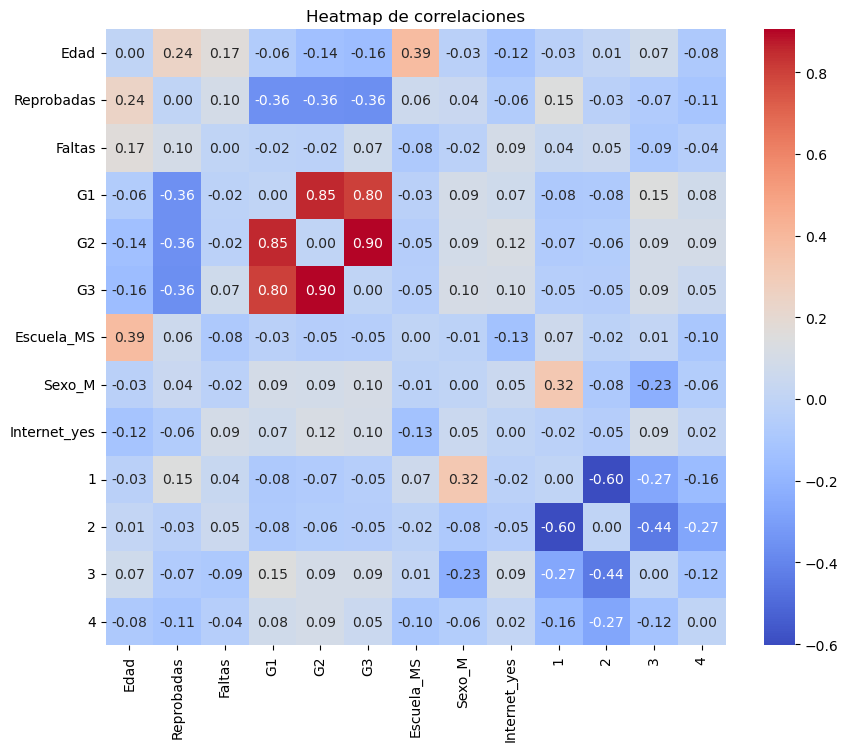

In [48]:
# Obtener valor absoluto de matriz de correlación
correlation_matrix = df.corr()

# Llenar la diagonal con ceros
np.fill_diagonal(correlation_matrix.values, 0)

# Obtener los indices (i,j) de la posición del valor máximo
i,j = np.unravel_index(np.abs(correlation_matrix.values).argmax(), correlation_matrix.shape)

# Imprimir los índices y el valor de la correlación máxima
print(f"Indices con mayor correlación: ({i}, {j})")
print(f"Valor de correlación máxima: {correlation_matrix.iloc[i, j]}")

# Generar un heatmap para visualizar los resultados
from seaborn import heatmap
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap de correlaciones")
plt.show()

Observaciones:
- La mayor correlación se tiene con las variables **G2** y **G3** (**0.90**), las cuales ambas son calificaciones correspondientes al segundo periodo y al periodo final del ciclo académico. Sin embargo, también se observan correlaciones altas entre las 3 variables correspondientes a las calificaciones de los 3 periodos académicos, unas mayores que otras.
    - Como las 3 variables están fuertemente correlacionadas, indica redundancia, por lo tanto, es necesario eliminar alguna de las variables correspondientes a los primeros dos periodos como **G1** o **G2**. 
- Hay una correlación negativa moderada entre **Reprobadas** y las calificaciones **G1**, **G2** y **G3**.
    - Como no es una correlación excesiva, puede mantenerse. 
- En todas demás variables no se observan correlaciones significativas.
    - Pueden mantenerse. 

Se elimina la variable **G1** del dataframe

In [54]:
df = df.drop("G1", axis=1)

# Comprobar eliminación imprimiendo las variables existentes 
print(df.dtypes)  

Edad            int64
Reprobadas      int64
Faltas          int64
G2              int64
G3              int64
Escuela_MS       bool
Sexo_M           bool
Internet_yes     bool
1                bool
2                bool
3                bool
4                bool
dtype: object


Al no mostrarse la variable G1 quiere decir que fue eliminada exitosamente.

5. Se quiere analizar si la relación entre **Edad** y **G3** cambia dependiendo del género del estudiante **Sexo_M** y si el efecto de **Faltas** sobre **G3** cambia dependiendo del acceso a internet. Por esa razón, las dos interacciones que se desean incluir son:
- **Edad x Sexo_M**: Para ver si la edad afecta diferente a hombres y mujeres.
- **Faltas x Internet_yes**: Para ver si el acceso a internet influye en cómo afectan las faltas.

Se realiza la separación de los datos en conjuntos de entrenamiento y prueba con una proporción **0.8/0.2**.

In [59]:
from sklearn.model_selection import train_test_split

# Generar subconjuntos de prueba y entrenamiento para X e Y
X_train, X_test, Y_train, Y_test = train_test_split(df.drop("G3", axis=1), df.G3, train_size=0.8)

# Imprimir tamaño de nuevos objetos
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(312, 11)
(78, 11)
(312,)
(78,)


In [61]:
# Concatenar Edad y Sexo en el indice 3 para X_train
X_train.insert(3, "Edad_Sexo", X_train.Edad * X_train.Sexo_M)

# Concatenar Edad y Sexo en el indice 3 para X_test
X_test.insert(3, "Edad_Sexo", X_test.Edad * X_test.Sexo_M)

# Concatenar Faltas e Internet en el indice 7 para X_train
X_train.insert(7, "Faltas_Internet", X_train.Faltas * X_train.Internet_yes)

# Concatenar Faltas e Internet en el indice 7 para X_test
X_test.insert(7, "Faltas_Internet", X_test.Faltas * X_test.Internet_yes)

# Imprimir primeras 5 observaciones de X_train
print("Observaciones de X_train")
X_train.head()

Observaciones de X_train


,Edad,Reprobadas,Faltas,Edad_Sexo,G2,Escuela_MS,Sexo_M,Faltas_Internet,Internet_yes,1,2,3,4
211,17,0,13,17,12,False,True,13,True,False,True,False,False
228,18,0,14,18,8,False,True,14,True,False,True,False,False
42,15,0,2,15,18,False,True,2,True,False,True,False,False
35,15,0,0,0,7,False,False,0,False,True,False,False,False
319,18,0,2,0,11,False,False,2,True,False,True,False,False


In [63]:
# Imprimir primeras 5 observaciones de X_test
print("Observaciones de X_test")
X_test.head()

Observaciones de X_test


,Edad,Reprobadas,Faltas,Edad_Sexo,G2,Escuela_MS,Sexo_M,Faltas_Internet,Internet_yes,1,2,3,4
342,18,0,11,18,15,False,True,11,True,False,True,False,False
175,17,0,4,17,9,False,True,4,True,False,True,False,False
138,16,1,0,16,12,False,True,0,False,False,True,False,False
18,17,3,16,17,5,False,True,16,True,True,False,False,False
253,16,0,0,16,9,False,True,0,False,True,False,False,False


6. Se entrena un modelo de regresión lineal múltiple en un subconjunto de datos que
corresponda al 80% de los datos totales y se imprime en consola un resumen de los
resultados obtenidos.

In [68]:
import statsmodels.api as sm 

# Convertir columnas booleanas a float
X_train = X_train.astype(float)

# Generar el modelo
model = sm.OLS(Y_train, sm.add_constant(X_train))

# Entrenar el modelo
results = model.fit()

# Imprimir resultados del modelo
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     G3   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     113.3
Date:                Sun, 09 Feb 2025   Prob (F-statistic):          1.55e-103
Time:                        03:15:50   Log-Likelihood:                -649.38
No. Observations:                 312   AIC:                             1325.
Df Residuals:                     299   BIC:                             1373.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               4.8763      1.946     

**Análisis de resultados**:
- **R² = 0.820** → El modelo explica el 82% de la variabilidad en G3. Es un valor alto, indicando un buen ajuste.
- **Adj. R² = 0.812** → Similar a R^2, pero penaliza por número de variables. Indica que el modelo no está sobreajustado.
- **F-statistic = 113.3 (p-value = 1.55e-103)** → Un valor de p extremadamente bajo, lo que indica que al menos una variable es significativamente diferente de 0 y el modelo tiene poder predictivo.
- G2 es extremadamente significativo y tiene una relación fuerte con G3 (coef = 1.1024, p = 0.000).
- Sexo_M tiene un coeficiente grande y negativo (-5.63), lo que sugiere que los hombres tienen calificaciones más bajas, aunque no es altamente significativo (p = 0.065).
- Edad tiene un efecto negativo y significativo en G3 (-0.49, p = 0.001).
- Las variables de interacción "Edad × Sexo" y "Faltas × Internet" no son muy significativas.

Se predice la calificación final del 20% de las observaciones que no se usaron para entrenar.

In [71]:
# Predecir peso de observaciones de prueba
yHat = results.predict(sm.add_constant(X_test))

Se Genera una gráfica de dispersión de las calificaciones finales reales contra las calificaciones finales estimadas
por el modelo en los datos de prueba.

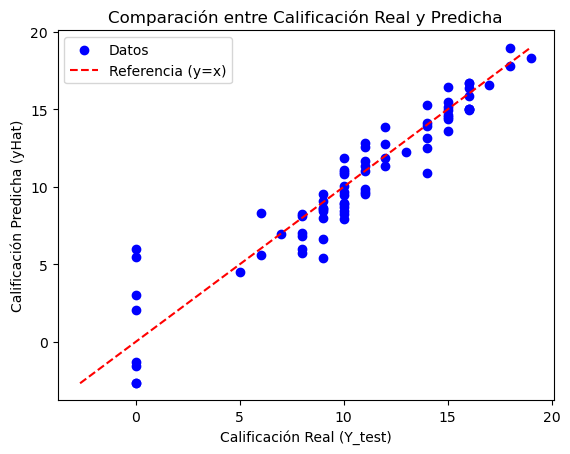

In [77]:
# Generar gráfica de dispersión
plt.scatter(Y_test, yHat, label="Datos", color="blue")
                       
# Agregar línea roja de referencia
min_val = min(min(Y_test), min(yHat)) # Mínimo de ambos ejes
max_val = max(max(Y_test), max(yHat)) # Máximo de ambos ejes
plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", label="Referencia (y=x)")

# Etiquetas y título
plt.xlabel("Calificación Real (Y_test)")
plt.ylabel("Calificación Predicha (yHat)")
plt.title("Comparación entre Calificación Real y Predicha")
plt.legend()
plt.show()

En la gráfica se puede observar que el modelo es preciso para calificaciones superiores a 5. Las diferencias entre las calificaciones reales y predichas no parecen ser grandes en ese rango de calificaciones, sin embargo, si lo llegan a ser para calificaciones inferiores a 5, aunque solo sean la minoría. Aún así, el modelo parece tener un muy buen ajuste. 